In [1]:
import os

# 设置默认编码为UTF-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Agent
- 目标是根据研究简报，搜集需要的上下文信息

# 提示词

In [2]:
from utils import show_prompt
from deep_research_from_scratch.my_prompts import research_agent_prompt

show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  您是一位研究助理，正在就用户输入的主题进行研究。作为背景信息，今天的日期是 {date}。                            │
│                                                                                                                 │
│  <任务>                                                                                                         │
│  您的工作是使用工具收集有关用户输入主题的信息。                                                                 │
│  您可以使用提供给您的任何工具来查找有助于回答研究问题的资源。您可以串行或并行调用这些工具，您的研究在一个工具   │
│  调用循环中进行。                                                                                               │
│  </任务>                                                                                                        │
│                                                                                                                 │
│  <可用工具>                                                                                                     │
│  您可以使用以下四类工具：                                                                                       │
│  1. **文件系统工具** - 用于从本地文件中收集信息。                                                               │
│    - **list_allowed_directories**: 查看您可以访问哪些目录                                                       │
│    - **list_directory**: 列出目录中的文件                                                                       │
│    - **read_file**: 读取单个文件                                                                                │
│    - **read_multiple_files**: 一次读取多个文件                                                                  │
│    - **search_files**: 查找包含特定内容的文件                                                                   │
│  2. **知识搜索工具** - 用于从知识库中收集信息。                                                                 │
│    - **knowledge_search**: 用于从知识库中收集信息。                                                             │
│  3. **网络搜索工具** - 用于进行网络搜索以收集信息。                                                             │
│    - **tavily_search**: 用于进行网络搜索以收集信息。                                                            │
│  4. **思维工具** - 用于在研究过程中进行反思和战略规划。                                                         │
│    - **think_tool**: 用于在研究过程中进行反思和战略规划。                                                       │
│                                                                                                                 │
│  **关键：每次搜索或阅读文件后使用 think_tool 来反思结果并计划下一步**                                           │
│  </可用工具>                                                                                                    │
│                                                                                                                 │
│  <说明>                                                                                                         │
│  像一个时间有限的人类研究员一样思考。请遵循以下步骤：                                                           │
│                                                                                                                 │
│  1. **仔细阅读问题** - 用户需要哪些具体信息？                                                                   │
│  2. **优先使用文件系统工具**                                                                                    │
│    - **优先浏览可用的文件** - 使用 list_allowed_directories 和 list_directory 来了解可用的文件                  │
│    - **识别相关文件** - 如果需要，使用 search_files 查找与主题匹配的文档                                        │
│    - **有策略地阅读** - 从最相关的文件开始，使用 read_multiple_files 以提高效率                                 │
│    - **阅读后，暂停并评估** - 我有足够的信息来回答吗？还缺少什么？                                              │
│  3. **在需要的时候，进行知识搜索**                                                                              │
│    - **仅在使用文件系统工具无法找到足够的信息时，才进行知识搜索。**                                             │
│    -

In [3]:
from utils import show_prompt
from deep_research_from_scratch.my_prompts import summarize_webpage_prompt

show_prompt(summarize_webpage_prompt, "summarize_webpage_prompt")

╭─────────────────────────────────────────── summarize_webpage_prompt ────────────────────────────────────────────╮
│                                                                                                                 │
│  您的任务是总结从网络搜索中检索到的网页原始内容。您的目标是创建一个保留原始网页最重要信息的摘要。该摘要将由下   │
│  游的研究代理使用，因此在不丢失基本信息的情况下保留关键细节至关重要。                                           │
│                                                                                                                 │
│  这是网页的原始内容：                                                                                           │
│                                                                                                                 │
│  <webpage_content>                                                                                              │
│  {webpage_content}                                                                                              │
│  </webpage_content>                                                                                             │
│                                                                                                                 │
│  请遵循以下准则创建您的摘要：                                                                                   │
│                                                                                                                 │
│  1.  识别并保留网页的主要主题或目的。                                                                           │
│  2.  保留内容信息核心的关键事实、统计数据和数据点。                                                             │
│  3.  保留来自可靠来源或专家的重要引述。                                                                         │
│  4.  如果内容具有时间敏感性或历史性，请保持事件的时间顺序。                                                     │
│  5.  如果存在列表或分步说明，请予以保留。                                                                       │
│  6.  包括对理解内容至关重要的相关日期、姓名和地点。                                                             │
│  7.  在保持核心信息完整的同时，总结冗长的解释。                                                                 │
│                                                                                                                 │
│  处理不同类型的内容时：                                                                                         │
│                                                                                                                 │
│  -   对于新闻文章：关注人物、事件、时间、地点、原因和方式（5W1H）。                                             │
│  -   对于科学内容：保留方法、结果和结论。                                                                       │
│  -   对于观点性文章：保留主要论点和支持论据。                                                                   │
│  -   对于产品页面：保留关键功能、规格和独特的卖点。                                                             │
│                                                                                                                 │
│  您的摘要应明显短于原始内容，但要足够全面，可以作为独立的信息来源。目标是达到原始内容长度的25-30%左右，除非内   │
│  容本身已经很简洁。                                                                                             │
│                                                                                                                 │
│  请按以下格式呈现您的摘要：                                                                                     │
│                                                                                                                 │
│  ```                                                                                                            │
│  {{                                                                                                             │
│     "summary": "您的摘要在此处，根据需要使用适当的段落或项目符号进行结构化",                                    │
│     "key_excerpts": "第一个重要引述或摘录, 第二个重要引述或摘录, 第三个重要引述或摘录,                          │
│  ...根据需要添加更多摘录，最多5个"                                                                              │
│  }}                                                                                           

In [4]:
from utils import show_prompt
from deep_research_from_scratch.my_prompts import compress_research_system_prompt

show_prompt(compress_research_system_prompt, "compress_research_system_prompt")

╭──────────────────────────────────────── compress_research_system_prompt ────────────────────────────────────────╮
│                                                                                                                 │
│  您是一位研究助理，通过调用多种工具和网络搜索对某一主题进行了研究。您的工作是清理研究结果，但要保留研究员收集   │
│  到的所有相关陈述和信息。作为背景信息，今天的日期是 {date}。                                                    │
│                                                                                                                 │
│  <任务>                                                                                                         │
│  您需要清理从现有信息中的工具调用和网络搜索中收集到的信息。                                                     │
│  所有相关信息都应以更清晰的格式逐字重复和重写。                                                                 │
│  此步骤的目的仅仅是删除任何明显不相关或重复的信息。                                                             │
│  例如，如果三个来源都说“X”，您可以说“这三个来源都陈述了X”。                                                     │
│  只有这些经过全面清理的调查结果才会返回给用户，因此不丢失原始信息中的任何信息至关重要。                         │
│  </任务>                                                                                                        │
│                                                                                                                 │
│  <工具调用过滤>                                                                                                 │
│  **重要提示**：在处理研究信息时，只关注实质性的研究内容：                                                       │
│  - **包括**：所有本地文件系统和网络搜索的发现。                                                                 │
│  - **排除**：think_tool 的调用和响应——这些是用于决策的内部代理反思，不应包含在最终研究报告中。                  │
│  - **关注**：从外部来源收集的实际信息，而不是代理的内部推理过程。                                               │
│                                                                                                                 │
│  think_tool 调用包含战略性反思和决策笔记，这些是研究过程的内部信息，但不包含应在最终报告中保留的事实信息。      │
│  </工具调用过滤>                                                                                                │
│                                                                                                                 │
│  <指南>                                                                                                         │
│  1. 您输出的调查结果应全面，并包括研究员从工具调用和网络搜索中收集到的所有信息和来源。期望您逐字重复关键信息。  │
│  2. 只要能返回研究员收集到的所有信息，这份报告可以任意长。                                                      │
│  3. 在您的报告中，您应该为研究员找到的每个来源返回内联引文。                                                    │
│  4. 您应该在报告末尾包含一个“来源”部分，列出研究员找到的所有来源及其相应的引文，并与报告中的陈述相对应。        │
│  5. 确保在报告中包括研究员收集到的所有来源，以及它们是如何被用来回答问题的！                                    │
│  6. 不丢失任何来源非常重要。稍后将使用一个LLM将此报告与其他报告合并，因此拥有所有来源至关重要。                 │
│  </指南>                                                                                                        │
│                                                                                                                 │
│  <输出格式>                                                                                                     │
│  报告应按以下结构组织：                                                                                         │
│  **进行的查询和工具调用列表**                                                                                   │
│  **全面详尽的调查结果**                                                                                         │
│  **所有相关来源列表（在报告中有引文）**                                                                         │
│  </输出格式>                                                                                                    │
│                                                                                                                 │
│  <引文规则>                                                                                                     │
│  - 为每个唯一的URL在文本中分配一个引文编号。                                                                    │
│  - 以 ### 来源 结尾，列出每个来源及其对应的编号。                                                   

In [5]:
from utils import show_prompt
from deep_research_from_scratch.my_prompts import compress_research_human_message

show_prompt(compress_research_human_message, "compress_research_human_message")

╭──────────────────────────────────────── compress_research_human_message ────────────────────────────────────────╮
│                                                                                                                 │
│  以上所有信息都是关于一位AI研究员为以下研究主题进行的研究：                                                     │
│                                                                                                                 │
│  研究主题：{research_topic}                                                                                     │
│                                                                                                                 │
│  您的任务是清理这些研究结果，同时保留所有与回答这个特定研究问题相关的信息。                                     │
│                                                                                                                 │
│  关键要求：                                                                                                     │
│  - 不要总结或转述信息——要逐字保留。                                                                             │
│  - 不要丢失任何细节、事实、姓名、数字或具体发现。                                                               │
│  - 不要过滤掉看起来与研究主题相关的信息。                                                                       │
│  - 以更清晰的格式组织信息，但保留所有实质内容。                                                                 │
│  - 包括研究期间找到的所有来源和引文。                                                                           │
│  - 请记住，进行此项研究是为了回答上述特定问题。                                                                 │
│                                                                                                                 │
│  清理后的研究结果将用于生成最终报告，因此全面性至关重要。                                                       │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# 定义state和schemas

In [6]:
%%writefile deep_research_from_scratch/state_research.py

"""定义用于Research Agent的state和pydantic的schemas"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ==== 定义state ====

class ResearcherState(TypedDict):
    """用于存储上下文信息"""
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """用于存储Research Agent的输出"""
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ==== 定义schemas ====

class ClarifyWithUser(BaseModel):
    """scoping澄清阶段的schema定义"""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question."
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    format_constraints: str = Field(
        description="The format constraints of the report.",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information."
    )

class ResearchQuestion(BaseModel):
    """用于生成研究简报的schema定义"""
    research_brief: str = Field(
        description="A research question that will be used to guide the research."
    )

class Summary(BaseModel):
    """用于网页内容总结的schema定义"""
    summary: str = Field(
        description="Concise summary of the webpage content"
    )
    key_excerpts: str = Field(
        description="Important quotes and excerpts from the content"
    )

Overwriting deep_research_from_scratch/state_research.py


# 定义tools

In [7]:
%%writefile deep_research_from_scratch/utils.py

"""Research工具定义"""

import os
import time
import asyncio
from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import AsyncTavilyClient

from deep_research_from_scratch.state_research import Summary
from deep_research_from_scratch.my_prompts import summarize_webpage_prompt

# ==== 常用函数定义 ====

def get_today_str() -> str:
    """获取当前日期字符串"""
    # 使用#代替-,避免跨平台问题
    return datetime.now().strftime("%a %b %#d, %Y")

def get_current_dir() -> Path:
    """获取当前模块的所在目录"""
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()

# ==== 配置 ====

# 本地MCP服务端-用于访问本地文件
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # 需要的话，自动安装
            "@modelcontextprotocol/server-filesystem",
            str(get_current_dir() / "files")  # 使用当前目录下的files文件夹
        ],
        "transport": "stdio",  # 使用stdio传输
        "env": {
            "LANG": "zh_CN.UTF-8",
            "LC_ALL": "zh_CN.UTF-8",
            "LC_CTYPE": "zh_CN.UTF-8"
        }
    }
}

# 全局的client，仅在需要的时候lazy初始化
_client = None

def get_mcp_client():
    """Lazy initialize the MCP client"""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client

# 初始化gpt模型
api_url = os.getenv('ARK_API_URL')
api_key = os.getenv('ARK_API_KEY')
model_name = os.getenv('ARK_MODEL')
summarization_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=32000
)
# 初始化tavily客户端
tavily_client = AsyncTavilyClient()

# ==== 搜索功能相关函数定义 ====

async def tavily_search_multiple(
    search_queries: List[str],
    max_results: int = 3,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> List[dict]:
    """
    使用tavily搜索多个查询
    
    Args:
        search_queries: 搜索查询列表
        max_results: 每个查询的最大结果数
        topic: 搜索主题
        include_raw_content: 是否包含原始网页内容
    Returns:
        List[dict]: 搜索结果列表, 每个结果包含url, title, snippet, raw_content
    """
    # 依次进行搜索（也可以使用AsyncTavilyClient进行并发搜索）
    search_docs = []
    coros = [
        tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic,
        ) for query in search_queries
    ]
    search_docs = await asyncio.gather(*coros)
    
    return search_docs

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """根据url去重"""
    unique_results = {}

    for response in search_results:
        for result in response["results"]:
            url = result["url"]
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

async def summarize_webpage_content(webpage_content: str) -> str:
    """
    使用LLM对网页内容进行总结和要点摘录
    
    Args:
        webpage_content: 网页内容
    Returns:
        str: 总结
    """
    try:
        # 检查内容长度，如果超过API限制则截断
        max_length = 80000  # 留一些缓冲空间，低于98304的限制
        if len(webpage_content) > max_length:
            # 尝试找到一个自然的截断点（段落结尾）
            truncated_content = webpage_content[:max_length]
            last_period = truncated_content.rfind('.')
            last_newline = truncated_content.rfind('\n')
            # 选择最近的段落或行结束点
            cutoff = max(last_period, last_newline) if max(last_period, last_newline) > max_length * 0.8 else max_length
            webpage_content = webpage_content[:cutoff] + "..."
            print(f"网页内容过长，已截断至 {len(webpage_content)} 字符")

        structured_model = summarization_model.with_structured_output(Summary)
        summary = await structured_model.ainvoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content,
                date=get_today_str()
            ))
        ])
        
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )
        return formatted_summary

    except Exception as e:
        print(f"总结网页时发生错误: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

async def process_search_results(unique_results: dict) -> dict:
    """
    处理搜索结果

    Args:
        unique_results: 去重后的搜索结果
    Returns:
        dict: 处理后的搜索结果
    """
    async def process_search_result_single(url: str, result: str):
        if not result.get("raw_content"):
            content = result["content"]
        else:
            # 总结内容
            content = await summarize_webpage_content(result["raw_content"])
        return url, {"title": result["title"], "content": content,}
        
    coros = [
        process_search_result_single(url, result)
        for url, result in unique_results.items()
    ]
    summarized_results_list = await asyncio.gather(*coros)

    return dict(summarized_results_list)

def format_search_output(summarized_results: dict) -> str:
    """
    格式化搜索结果

    Args:
        summarized_results: 处理后的搜索结果
    Returns:
        str: 格式化后的搜索结果
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i} {result["title"]} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result["content"]}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ==== 定义tools ====

# 搜索工具
@tool(parse_docstring=True)
async def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # 单次搜索
    print(f"当前搜索query: {query}")
    search_results = await tavily_search_multiple(
        [query],
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # 结果去重
    unique_results = deduplicate_search_results(search_results)

    # 总结页面内容
    summarized_results = await process_search_results(unique_results)

    # 格式化搜索结果
    formatted_output = format_search_output(summarized_results)

    return formatted_output

# 反思工具
# 有意思的是，反思工具的功能是通过docstring的描述定义的（效果类似于prompt）
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """

    return f"Reflection recorded: {reflection}"


Overwriting deep_research_from_scratch/utils.py


# 定义工作流

In [8]:
%%writefile deep_research_from_scratch/research_agent.py

"""实现Research Agent，通过多次搜索和整合回答研究问题"""

import os
import asyncio
from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import (
    SystemMessage, 
    HumanMessage, 
    ToolMessage, 
    filter_messages
)
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import (
    tavily_search,
    get_mcp_client,
    get_today_str, 
    think_tool
)
from .ragflow_tool import knowledge_search
from deep_research_from_scratch.my_prompts import (
    research_agent_prompt,
    compress_research_system_prompt,
    compress_research_human_message
)

# ==== 配置 ====

# 初始化模型
api_url = os.getenv('ARK_API_URL')
api_key = os.getenv('ARK_API_KEY')
model_name = os.getenv('ARK_MODEL')
model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=32000
)
compress_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=32000
)

# ==== agent节点 ====

async def llm_call(state: ResearcherState):
    """后续action的判断
    
    根据当前的对话内容，判断后续的action：
    1. 如果需要继续收集信息，则调用mcp或tavily_search工具
    2. 根据收集到的信息，给出最终回答
    """
    # 获取可用工具
    client = get_mcp_client()
    mcp_tools = await client.get_tools()

    # 工具设置
    tools = mcp_tools + [knowledge_search, tavily_search, think_tool]

    # 工具绑定
    model_with_tools = model.bind_tools(tools)
    
    # llm with tools
    return {
        "researcher_messages": [
            await model_with_tools.ainvoke(
                [SystemMessage(content=research_agent_prompt.format(date=get_today_str()))] 
                + state["researcher_messages"]
            )
        ]
    }

async def tool_node(state: ResearcherState):
    """工具执行"""
    tool_calls = state["researcher_messages"][-1].tool_calls

    # 执行工具
    async def execute_tools():
        """执行工具"""
        # 获取最新的工具信息
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = mcp_tools + [knowledge_search, tavily_search, think_tool]
        tools_by_name = {tool.name: tool for tool in tools}

        # 异步执行工具
        async def execute_single_tool(tool_call):
            """执行单个工具"""
            tool = tools_by_name[tool_call["name"]]
            if tool_call["name"] == "think_tool":
                # think_tool采用同步执行，但包装成异步，避免阻塞主线程(使用其它线程运行，会导致langsmith的追踪有问题)
                # loop = asyncio.get_event_loop()
                # observation = await loop.run_in_executor(None, tool.invoke, tool_call["args"])
                observation = tool.invoke(tool_call["args"])
            else:
                # mcp和搜索工具采用异步执行
                observation = await tool.ainvoke(tool_call["args"])
            return observation
        
        # 创建所有工具执行任务
        tasks = [execute_single_tool(tool_call) for tool_call in tool_calls]

        # 并行执行所有任务，并保持顺序
        observations = await asyncio.gather(*tasks)
        
        # 格式化输出
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs
    
    messages = await execute_tools()

    return {"researcher_messages": messages}

async def compress_research(state: ResearcherState) -> dict:
    """压缩research相关的信息"""
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    used_compress_research_human_message = compress_research_human_message
    if state.get("research_topic", ""):
        used_compress_research_human_message = used_compress_research_human_message.format(
            research_topic=state.get("research_topic")
        )
    else:
        used_compress_research_human_message = used_compress_research_human_message.format(
            research_topic=state.get("research_brief")
        )
    messages = [SystemMessage(content=system_message)] \
        + state.get("researcher_messages", []) \
        + [HumanMessage(content=used_compress_research_human_message)]
    response = await compress_model.ainvoke(messages)

    # 保留原始工具调用信息和LLM的输出
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"],
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ==== 路由逻辑 ====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """根据当前的对话内容，判断是否需要继续research的循环"""
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # 如果最后一条消息是tool_message，则继续research
    if last_message.tool_calls:
        return "tool_node"
    return "compress_research"

# ==== 定义graph ====

# 创建agent的工作流
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# 添加节点
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# 添加边（edges）
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,  # 判断条件
    {
        "tool_node": "tool_node",
        "compress_research": "compress_research",
    }
)
agent_builder.add_edge("tool_node", "llm_call")
agent_builder.add_edge("compress_research", END)

# 编译
researcher_agent = agent_builder.compile()

Overwriting deep_research_from_scratch/research_agent.py


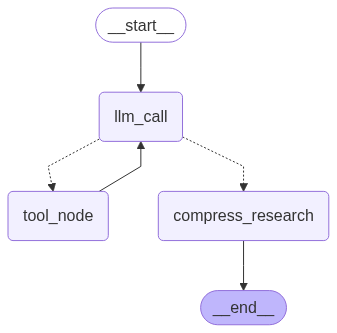

In [9]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent import researcher_agent

# 可视化工作流
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

# 运行工作流（测试）

In [ ]:
from utils import format_messages
from langchain_core.messages import HumanMessage

# 研究简报示例
research_brief = (
    "我需要一份关于特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术的研究报告，具体聚焦于孤岛工作面临空巷道、断层、火"
    "成岩侵入区、淋水区等地质条件下8224、8123、8322工作面回采巷道和高抽巷道的稳定性控制。报告需包含以下章节：一、项目提"
    "出背景（现状及存在问题）；二、项目立项的必要性；三、相关领域国内外技术现状、发展趋势及现有工作基础；四、项目目标、"
    "主要研究内容、技术指标；五、项目实施方案、技术关键（包括技术难点、创新点）；六、项目承担单位的支撑条件（包括组织措"
    "施、原辅材料供应、企业公用设施等配套条件）；七、项目计划进度。研究方法需结合模拟推演与现场监测，重点包括巷道掘进期"
    "的快速成巷技术、回采期的动态补强与顶板卸压方案、围岩变形预测模型构建、机器学习算法分析围岩变形规律、动态优化围岩控"
    "制参数，以实现从掘进到回采全过程的围岩稳定性精准控制，保障巷道安全高效服役。优先参考学术期刊论文、行业技术报告及现"
    "场实践案例，确保技术细节和数据的准确性。"
).strip()
format_constraints = (
    "研究报告必须包含以下章节："
    "一、项目提出背景（现状及存在问题）"
    "二、项目立项的必要性"
    "三、相关领域国内外技术现状、发展趋势及现有工作基础"
    "四、项目目标、主要研究内容、技术指标"
    "五、项目实施方案、技术关键（包括技术难点、创新点）"
    "六、项目承担单位的支撑条件（包括组织措施、原辅材料供应、企业公用设施等配套条件）"
    "七、项目计划进度"
).strip()

config = {"recursion_limit": 50}
result = await researcher_agent.ainvoke({
    "researcher_messages": [
        HumanMessage(content=f"{research_brief}"),
        HumanMessage(content=f"{format_constraints}")
    ]
}, config=config)
format_messages(result["researcher_messages"])

## 查看总结后的研究内容

In [ ]:
from rich.markdown import Markdown
Markdown(result["compressed_research"])

进行的查询和工具调用列表                                                                                           

研究员进行了以下搜索查询和工具调用来收集信息：                                                                     

 1 搜索：特厚煤层 孤岛工作面 临空巷道 断层 火成岩侵入 淋水区 巷道围岩稳定性控制技术 全生命周期                     
 2 搜索：特厚煤层 巷道围岩稳定性 全生命周期控制 快速成巷技术 动态补强 顶板卸压 机器学习 变形预测                   
 3 搜索：8224 8123 8322工作面 回采巷道 高抽巷道 围岩稳定性控制 断层 火成岩侵入 淋水区                              
 4 搜索：孤岛工作面 临空巷道 围岩稳定性控制技术 巷道支护 强矿压 冲击地压防治                                       
 5 搜索："断层带巷道支护" "火成岩侵入区巷道" "淋水区巷道稳定性" 注浆加固 围岩控制技术                              
 6 读取本地文件：赵庄矿项目-可行性研究报告初稿.md                                                                  
 7 读取本地文件：附件2晋能控股煤业集团科技研发计划项目可行性研究报告.md                                            

全面详尽的调查结果                                                                                                 

以下是研究员从所有工具调用和网络搜索中收集到的所有相关信息，按研究主题组织并逐字保留：                             

一、项目提出背景（现状及存在问题）                                                                                 

从本地文件 赵庄矿项目-可行性研究报告初稿.md [1] 中收集到：                                                         

 • 随着煤矿开采向深部延伸，强矿压巷道面临复合地质环境，冲击地压、瓦斯突出、水害等多灾种耦合风险显著加剧。          
 • 传统监测多聚焦单一要素、覆盖周期局限于掘进阶段，难以捕捉 “地质构造演化—应力集中—围岩失稳—灾害触发”              
   的全链条动态过程。历史案例显示，强矿压灾害的发生往往是多要素长期累积、相互作用的结果，若缺乏全周期、多要素的协同
   监测，易因关键信息缺失导致预警滞后或误判，进而引发恶性安全事故。                                                
 • 当前监测体系存在明显短板：要素监测呈碎片化状态，周期覆盖不完整，重掘进阶段轻后期服务周期，难以捕捉长期演化的灾害
   隐患；预警响应滞后，人工解析效率低，与灾害突发性特点不匹配，易导致安全事故。                                    

二、项目立项的必要性                                                                                               

从本地文件 赵庄矿项目-可行性研究报告初稿.md [1] 中收集到：                                                         

 • 开展强矿压巷道多要素全周期监测技术研究与应用项目具有极强的必要性，是应对深部煤矿开采复杂挑战的关键举措。        
 • 通过全周期监测实现对 “地质构造、应力演化、围岩变形、水压变化”                                                   
   等要素的全程追踪，是阻断灾害链、降低事故风险的核心手段。                                                        
 • 该项目通过构建全周期多要素监测体系，可实现对地质构造、应力演化等关键要素的全程追踪，精准识别复合风险，填补现有技
   术空白。项目成果可推动强矿压巷道监测技术从静态单一监测向动态协同感知升级，响应国家智能化灾害防控政策，为深部资源
   安全高效开采提供重要支撑。                                                                                      

三、相关领域国内外技术现状、发展趋势及现有工作基础                                                                 

3.1 国内外技术现状                                                                                                 

从本地文件 赵庄矿项目-可行性研究报告初稿.md [1] 中收集到：                                                         

 • 在掘进超前探测技术层面，物探技术作为前期筛查的核心手段广泛应用，其中地震波法（如反射地震、瑞利波勘探）通过分析波
   速变化识别断层、裂隙等构造异常，电磁法（如瞬变电磁、直流电法）则在富水带探测中发挥重要作用，可有效定位高水压区域
   ；钻探技术作为验证性手段，通过定向钻探结合岩芯取样，精准验证物探发现的地质异常区，同时获取岩体物理力学参数，为后
   续分析提供基础数据；近年来新型探测技术不断涌现，如应力场精细探测技术通过弹性波                                  
   CT、声波测井等手段反演应力集中区，量子传感技术开始尝试在高干扰环境下实现微弱信号捕捉，提升应力探测的灵敏度。    
 • 在回采长时监测技术层面，传感器网络构建成为实时感知的核心支撑，光纤传感、微震监测、应力传感器等设备实现多参数同步
   采集：光纤传感器凭借抗电磁干扰、分布式监测优势，可实时捕捉巷道围岩变形与应力应变；微震监测系统通过捕捉岩体破裂释
   放的能量信号，预警冲击地压风险；瓦斯、水压传感器则与通风、排水系统联动，实现有害气体与水害的动态监测。同时，实时
   传输与数据平台建设逐步完善，5G、工业以太网等技术保障监测数据低延迟传输，监测平台整合多源数据形成可视化看板，为现
   场决策提供直观依据。                                                                                            
 • 但这些技术在应用过程中仍面临多重挑战：高应力环境下岩体非均质性强，地震波、电磁信号易受散射、衰减影响，导致构造与
   应力异常的定位精度不足；多因素耦合效应加剧识别难度，瓦斯、水压、应力的相互作用使单一参数监测难以反映真实风险，多
   参数关联分析模型尚不完善；部分设备在极端环境适应性有限，高瓦斯区域对电磁设备防爆等级要求严苛，高水压环境下传感器
   密封性、耐久性待提升；实时监测的 “数据洪流”                                                                     
   与超前预警需求存在矛盾，数据传输延迟、算法响应速度不足导致预警滞后，难以满足深部巷道快速掘进的安全管控需求。    

从网络搜索 (SOURCE 2) [3] 中收集到关于破碎围岩控制技术：                                                           

 • 该成果开发了动压、破碎围岩巷道稳定控制技术，包括沿空掘巷围岩控制技术、迎采巷道围岩控制技术和破碎围岩巷道注浆加固
   技术。通过改善围岩应力环境，结合注浆加固与锚杆联合支护，显著提高巷道稳定性。技术特点基于弧形三角块力学模型研究，
   适用于沿空掘巷、地质构造带等破碎围岩条件。                                                                      
 • 通过采用自主研制的注浆材料加固围岩、改善围岩性质、提高围岩的整体性和自承载能力，并与锚杆支护相结合，能提高锚杆锚
   固力、增大支护阻力，充分发挥两种支护的优势，能够显著改善迎采巷道维护状况。                                      
 • 通过建立弧形三角块力学模型，研究